<a href="https://colab.research.google.com/github/Davisdenner/MVP---Machine-Learning-Analytics/blob/main/MVP_Machine_Learning_Analytics3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
# ============================================================================#
# PROJETO DE DEEP LEARNING PARA PROCESSAMENTO DE LINGUAGEM NATURAL
# Problema: Classificação de Tweets de Desastre
# ============================================================================#

#Imports necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

#Bibliotecas de Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, Embedding, Dropout, Bidirectional,GlobalMaxPool1D, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input, concatenate)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

#Otimização de hiperparâmetros
from sklearn.model_selection import GridSearchCV

#Para visualizações
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

#Para processamento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Configuração para não exibir warnings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
%matplotlib inline


=== ANÁLISE EXPLORATÓRIA DOS DADOS ===
Dimensões do conjunto de treino: (7613, 5)
Dimensões do conjunto de teste: (3263, 4)

Valores nulos no treino: 2594
Valores nulos no teste: 1131

Distribuição da variável target:
target
0    4342
1    3271
Name: count, dtype: int64
Proporção: 57.03% Não-Desastre, 42.97% Desastre


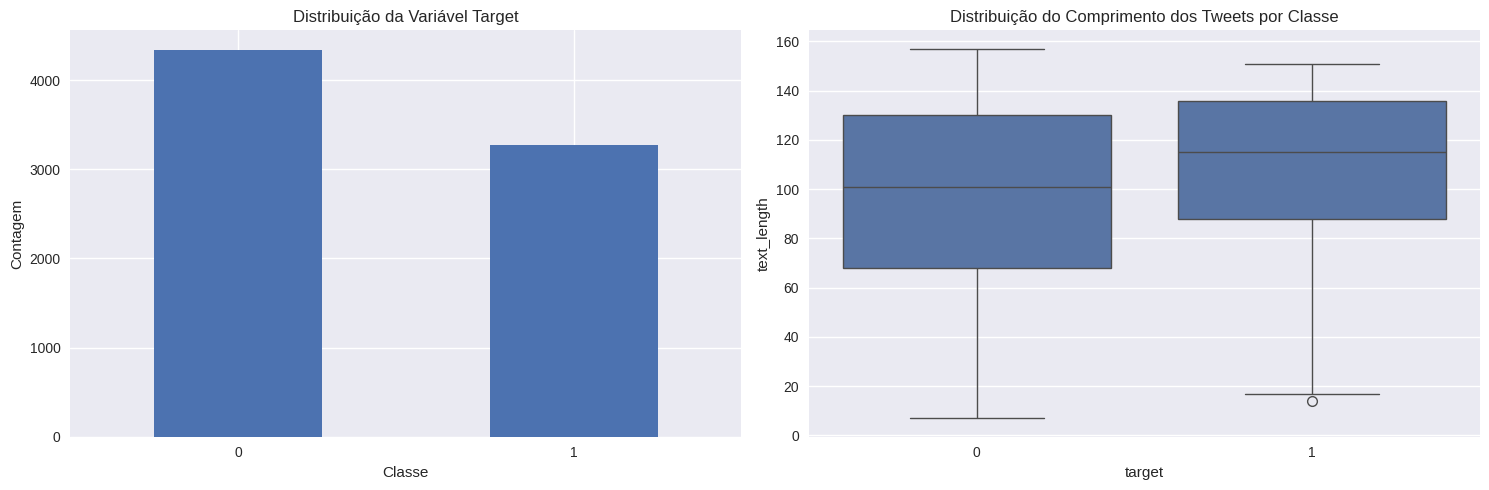

In [68]:
# ============================================================================
# 1. CARGA E EXPLORAÇÃO DOS DADOS
# ============================================================================

#Baixando recursos do NLTK necessários
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

#Carregando os dados
train_df = pd.read_csv(r"https://raw.githubusercontent.com/Davisdenner/MVP---Machine-Learning-Analytics/main/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/Davisdenner/MVP---Machine-Learning-Analytics/main/test.csv")

print("=== ANÁLISE EXPLORATÓRIA DOS DADOS ===")
print(f"Dimensões do conjunto de treino: {train_df.shape}")
print(f"Dimensões do conjunto de teste: {test_df.shape}")

#Verificando valores nulos
print(f"\nValores nulos no treino: {train_df.isnull().sum().sum()}")
print(f"Valores nulos no teste: {test_df.isnull().sum().sum()}")

#Distribuição da variável target
print(f"\nDistribuição da variável target:")
target_dist = train_df['target'].value_counts()
print(target_dist)
print(f"Proporção: {target_dist[0] / len(train_df):.2%} Não-Desastre, {target_dist[1] / len(train_df):.2%} Desastre")

#Visualização da distribuição
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Contagem
train_df['target'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribuição da Variável Target')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Contagem')
axes[0].tick_params(axis='x', rotation=0)

#Comprimento dos tweets
train_df['text_length'] = train_df['text'].apply(len)
sns.boxplot(x='target', y='text_length', data=train_df, ax=axes[1])
axes[1].set_title('Distribuição do Comprimento dos Tweets por Classe')

plt.tight_layout()
plt.show()

In [69]:
# ============================================================================
# 2. PREPARAÇÃO E PRÉ-PROCESSAMENTO DOS DADOS
# ============================================================================

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    #Convertendo para minúsculo
    text = text.lower()

    #Removendo URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    #Removendo menções e hashtags (manter o conteúdo)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    #Removendo caracteres especiais, manter espaços
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Removendo espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    #Tokenização
    tokens = word_tokenize(text)


    #Removendo stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    #Lematização
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


#Aplicando pré-processamento
print("Aplicando pré-processamento nos dados...")
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

#Estatísticas do texto processado
print(f"Textos vazios após processamento (treino): {train_df['processed_text'].str.len().eq(0).sum()}")
print(f"Comprimento médio do texto processado: {train_df['processed_text'].str.len().mean():.1f}")

#Removendo textos vazios
train_df = train_df[train_df['processed_text'].str.len() > 0]
print(f"Dados restantes após limpeza: {len(train_df)}")

Aplicando pré-processamento nos dados...
Textos vazios após processamento (treino): 1
Comprimento médio do texto processado: 57.9
Dados restantes após limpeza: 7612


Tamanhos dos conjuntos:
Treino: 6089 (80.0%)
Validação: 1523 (20.0%)
Teste: 3263


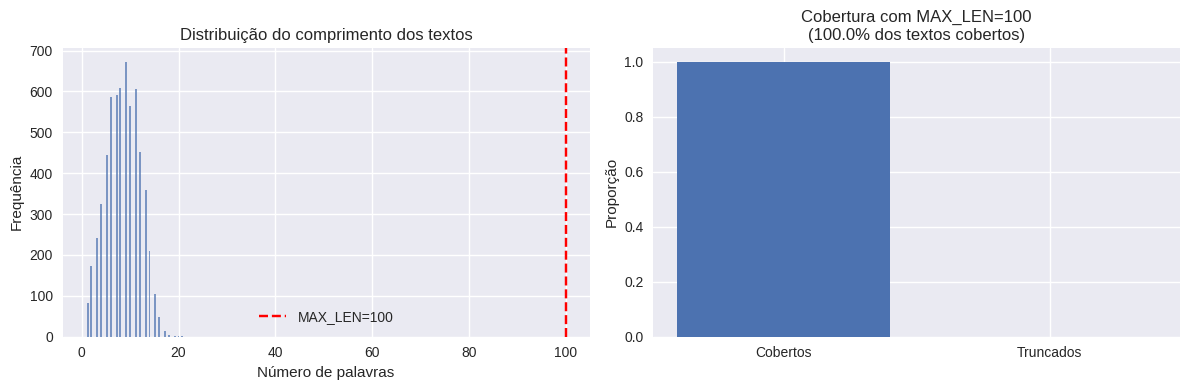


Após tokenização e padding:
Shape treino: (6089, 100)
Shape validação: (1523, 100)
Shape teste: (3263, 100)
Tamanho do vocabulário: 11482


In [70]:
# ============================================================================
# 3. SEPARAÇÃO TREINO/VALIDAÇÃO/TESTE E TOKENIZAÇÃO
# ============================================================================

#Preparando dados
X = train_df['processed_text']
y = train_df['target']

#Divisão estratificada treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanhos dos conjuntos:")
print(f"Treino: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validação: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Teste: {len(test_df)}")

#Configurações para tokenização
MAX_FEATURES = 20000  #Tamanho do vocabulário
MAX_LEN = 100  #Comprimento máximo das sequências

#Análise do comprimento das sequências
text_lengths = X_train.apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, alpha=0.7)
plt.axvline(MAX_LEN, color='red', linestyle='--', label=f'MAX_LEN={MAX_LEN}')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.title('Distribuição do comprimento dos textos')
plt.legend()

plt.subplot(1, 2, 2)
coverage = (text_lengths <= MAX_LEN).mean()
plt.bar(['Cobertos', 'Truncados'], [coverage, 1 - coverage])
plt.title(f'Cobertura com MAX_LEN={MAX_LEN}\n({coverage:.1%} dos textos cobertos)')
plt.ylabel('Proporção')

plt.tight_layout()
plt.show()

#Tokenização
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

#Convertendo textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['processed_text'])

#Padding das sequências
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"\nApós tokenização e padding:")
print(f"Shape treino: {X_train_pad.shape}")
print(f"Shape validação: {X_val_pad.shape}")
print(f"Shape teste: {X_test_pad.shape}")
print(f"Tamanho do vocabulário: {len(tokenizer.word_index)}")

In [71]:
# ============================================================================
# 4. MODELOS DE DEEP LEARNING - ARQUITETURAS DIFERENTES
# ============================================================================

def create_simple_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_bidirectional_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
        GlobalMaxPool1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_cnn_model(vocab_size, embedding_dim=128):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_hybrid_model(vocab_size, embedding_dim=128):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(50, dropout=0.5, recurrent_dropout=0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


#Criando todos os modelos
models = {
    'LSTM_Simples': create_simple_lstm(MAX_FEATURES),
    'LSTM_Bidirecional': create_bidirectional_lstm(MAX_FEATURES),
    'CNN': create_cnn_model(MAX_FEATURES),
    'CNN_LSTM_Híbrido': create_hybrid_model(MAX_FEATURES)
}

#Mostrando arquiteturas
for name, model in models.items():
    print(f"\n=== ARQUITETURA {name} ===")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, MAX_LEN))  # Construir o modelo
    print(f"Parâmetros treináveis: {model.count_params():,}")


=== ARQUITETURA LSTM_Simples ===
Parâmetros treináveis: 2,611,521

=== ARQUITETURA LSTM_Bidirecional ===
Parâmetros treináveis: 2,669,185

=== ARQUITETURA CNN ===
Parâmetros treináveis: 2,640,193

=== ARQUITETURA CNN_LSTM_Híbrido ===
Parâmetros treináveis: 2,610,969


In [72]:
# ============================================================================
# 5. TREINAMENTO DOS MODELOS
# ============================================================================

#Callbacks para otimização do treinamento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
]

#Dicionário para armazenar históricos e resultados
results = {}
histories = {}

print("=== INICIANDO TREINAMENTO DOS MODELOS ===\n")

for name, model in models.items():
    print(f"Treinando {name}...")

    #Treinando modelo
    history = model.fit(
        X_train_pad, y_train,
        epochs=15,
        batch_size=32,
        validation_data=(X_val_pad, y_val),
        callbacks=callbacks,
        verbose=0
    )

    #Avaliando o modelo
    val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
    y_pred = (model.predict(X_val_pad, verbose=0) > 0.5).astype(int).flatten()

    #Armazenando os resultados
    results[name] = {
        'model': model,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'predictions': y_pred,
        'epochs_trained': len(history.history['loss'])
    }
    histories[name] = history.history

    print(f"✓ {name}: Acurácia = {val_accuracy:.4f}, Loss = {val_loss:.4f}, Épocas = {len(history.history['loss'])}\n")

print("=== TREINAMENTO CONCLUÍDO ===")

=== INICIANDO TREINAMENTO DOS MODELOS ===

Treinando LSTM_Simples...

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
✓ LSTM_Simples: Acurácia = 0.8083, Loss = 0.4414, Épocas = 5

Treinando LSTM_Bidirecional...

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
✓ LSTM_Bidirecional: Acurácia = 0.7932, Loss = 0.4475, Épocas = 5

Treinando CNN...

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
✓ CNN: Acurácia = 0.7925, Loss = 0.4535, Épocas = 5

Treinando CNN_LSTM_Híbrido...

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
✓ CNN_LSTM_Híbrido: Acurácia = 

In [73]:
# ============================================================================
# 6. OTIMIZAÇÃO DE HIPERPARÂMETROS (MELHOR MODELO)
# ============================================================================

#Identificando o melhor modelo base
best_base_model = max(results.keys(), key=lambda k: results[k]['val_accuracy'])
print(f"Melhor modelo base: {best_base_model} (Acurácia: {results[best_base_model]['val_accuracy']:.4f})")


#Otimização de hiperparâmetros para o melhor modelo
def create_optimized_model(embedding_dim=128, lstm_units=64, dense_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)),
        GlobalMaxPool1D(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate / 2),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


#Configurações de hiperparâmetros para testar
hyperparams_configs = [
    {'embedding_dim': 128, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001},
    {'embedding_dim': 256, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0005},
    {'embedding_dim': 128, 'lstm_units': 100, 'dense_units': 80, 'dropout_rate': 0.6, 'learning_rate': 0.002}
]

print("=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===")
best_hyperparams = None
best_hp_score = 0

for i, params in enumerate(hyperparams_configs):
    print(f"\nTestando configuração {i + 1}: {params}")

    #Criando e treinar modelo
    model = create_optimized_model(**params)

    history = model.fit(
        X_train_pad, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val_pad, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0
    )

    #Avaliando
    val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
    print(f"Acurácia: {val_accuracy:.4f}")

    if val_accuracy > best_hp_score:
        best_hp_score = val_accuracy
        best_hyperparams = params
        best_optimized_model = model

print(f"\n Melhores hiperparâmetros: {best_hyperparams}")
print(f" Melhor acurácia otimizada: {best_hp_score:.4f}")

Melhor modelo base: LSTM_Simples (Acurácia: 0.8083)
=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===

Testando configuração 1: {'embedding_dim': 128, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001}
Acurácia: 0.8076

Testando configuração 2: {'embedding_dim': 256, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
Acurácia: 0.8142

Testando configuração 3: {'embedding_dim': 128, 'lstm_units': 100, 'dense_units': 80, 'dropout_rate': 0.6, 'learning_rate': 0.002}
Acurácia: 0.5706

✓ Melhores hiperparâmetros: {'embedding_dim': 256, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
✓ Melhor acurácia otimizada: 0.8142


=== COMPARAÇÃO FINAL DOS MODELOS DE DEEP LEARNING ===
              Modelo  Acurácia           Tipo
4     LSTM_Otimizado    0.8142  Deep Learning
0       LSTM_Simples    0.8083  Deep Learning
3   CNN_LSTM_Híbrido    0.7938  Deep Learning
1  LSTM_Bidirecional    0.7932  Deep Learning
2                CNN    0.7925  Deep Learning

=== ANÁLISE COMPARATIVA ===
Melhor modelo: LSTM_Otimizado (Acurácia: 0.8142)
• LSTM_Simples: 0.8083 (diferença: -0.0059)
• CNN_LSTM_Híbrido: 0.7938 (diferença: -0.0204)
• LSTM_Bidirecional: 0.7932 (diferença: -0.0210)
• CNN: 0.7925 (diferença: -0.0217)


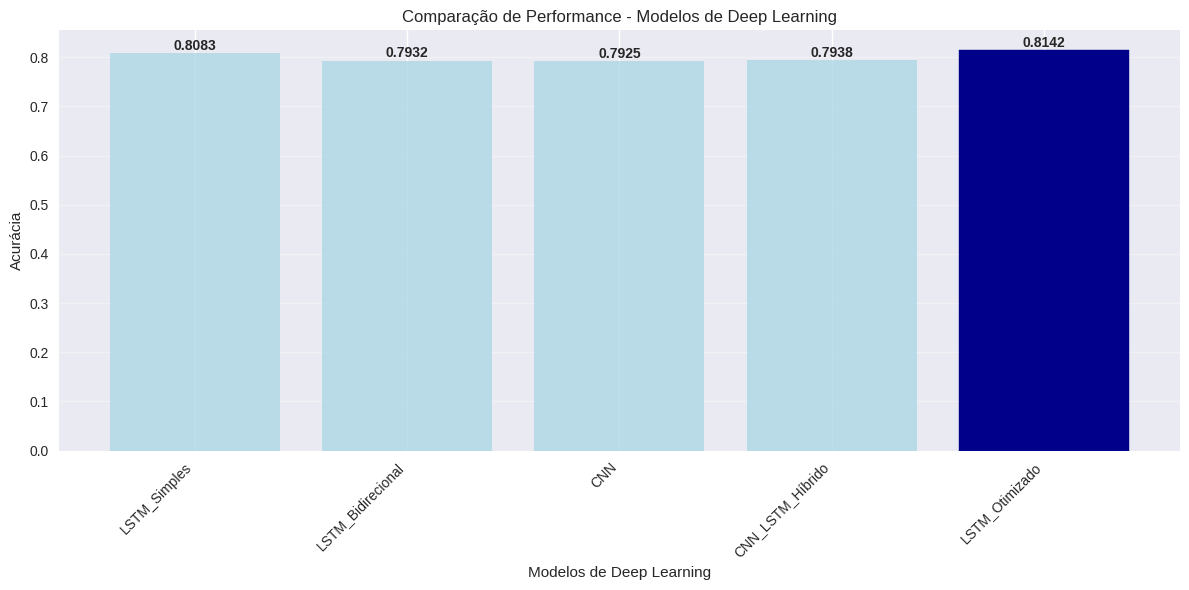


=== ESTATÍSTICAS DOS MODELOS DE DEEP LEARNING ===
Total de modelos avaliados: 5
Acurácia média: 0.8004
Desvio padrão: 0.0101
Variação (máx - mín): 0.0217

 Modelo selecionado para predições finais: LSTM_Otimizado
 Acurácia na validação: 0.8142


In [74]:
# ============================================================================
# 7. AVALIAÇÃO E COMPARAÇÃO DOS RESULTADOS - APENAS DEEP LEARNING
# ============================================================================

#Adicionando modelo otimizado aos resultados
y_pred_optimized = (best_optimized_model.predict(X_val_pad, verbose=0) > 0.5).astype(int).flatten()
results['LSTM_Otimizado'] = {
    'model': best_optimized_model,
    'val_accuracy': best_hp_score,
    'predictions': y_pred_optimized
}



#Comparando de resultados
dl_results = {k: v for k, v in results.items() if 'model' in v}

comparison_df = pd.DataFrame({
    'Modelo': list(dl_results.keys()),
    'Acurácia': [dl_results[k]['val_accuracy'] for k in dl_results.keys()],
    'Tipo': ['Deep Learning'] * len(dl_results)
})

print("=== COMPARAÇÃO FINAL DOS MODELOS DE DEEP LEARNING ===")
comparison_sorted = comparison_df.sort_values('Acurácia', ascending=False)
print(comparison_sorted.round(4))

#Mostrando diferenças entre modelos
best_dl_acc = comparison_sorted.iloc[0]['Acurácia']
print(f"\n=== ANÁLISE COMPARATIVA ===")
print(f"Melhor modelo: {comparison_sorted.iloc[0]['Modelo']} (Acurácia: {best_dl_acc:.4f})")
for i in range(1, len(comparison_sorted)):
    model_name = comparison_sorted.iloc[i]['Modelo']
    model_acc = comparison_sorted.iloc[i]['Acurácia']
    diff = best_dl_acc - model_acc
    print(f"• {model_name}: {model_acc:.4f} (diferença: -{diff:.4f})")

#Visualização comparativa
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(comparison_df)), comparison_df['Acurácia'],
               color='lightblue', alpha=0.8)
plt.xlabel('Modelos de Deep Learning')
plt.ylabel('Acurácia')
plt.title('Comparação de Performance - Modelos de Deep Learning')
plt.xticks(range(len(comparison_df)), comparison_df['Modelo'], rotation=45, ha='right')

#Adicionando valores nas barras
for bar, acc in zip(bars, comparison_df['Acurácia']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

#Destacando o melhor modelo
best_idx = comparison_df['Acurácia'].idxmax()
bars[best_idx].set_color('darkblue')
bars[best_idx].set_alpha(1.0)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#Estatísticas adicionais dos modelos DL
print(f"\n=== ESTATÍSTICAS DOS MODELOS DE DEEP LEARNING ===")
print(f"Total de modelos avaliados: {len(dl_results)}")
print(f"Acurácia média: {comparison_df['Acurácia'].mean():.4f}")
print(f"Desvio padrão: {comparison_df['Acurácia'].std():.4f}")
print(f"Variação (máx - mín): {comparison_df['Acurácia'].max() - comparison_df['Acurácia'].min():.4f}")

#Identificando o melhor modelo para uso posterior
best_dl_model_name = comparison_sorted.iloc[0]['Modelo']
best_dl_model = dl_results[best_dl_model_name]['model']

print(f"\n Modelo selecionado para predições finais: {best_dl_model_name}")
print(f" Acurácia na validação: {dl_results[best_dl_model_name]['val_accuracy']:.4f}")

=== MODELOS DE DEEP LEARNING DISPONÍVEIS ===
• LSTM_Simples: Acurácia 0.8083
• LSTM_Bidirecional: Acurácia 0.7932
• CNN: Acurácia 0.7925
• CNN_LSTM_Híbrido: Acurácia 0.7938
• LSTM_Otimizado: Acurácia 0.8142

=== ANÁLISE DO MELHOR MODELO: LSTM_Otimizado ===
Acurácia: 0.8142
Tipo: Deep Learning Neural Network

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

Não Desastre       0.79      0.92      0.85       869
    Desastre       0.87      0.67      0.76       654

    accuracy                           0.81      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523



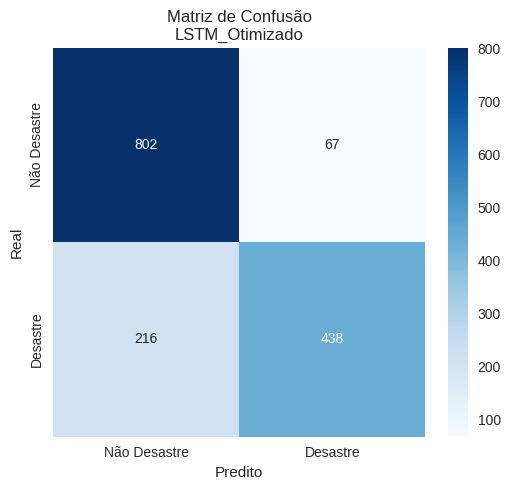


=== ANÁLISE DE ERROS ===
Total de predições corretas: 1240 (81.4%)
Total de predições incorretas: 283 (18.6%)

Tipos de erro:
• Falsos Positivos: 67 (4.4%)
• Falsos Negativos: 216 (14.2%)

=== EXEMPLOS DE FALSOS POSITIVOS ===
(Predito como desastre, mas não é)
1. firefighter acted like cop theyd drive around shooting flamethrower burning building...
2. ignition knock detonation sensorsenso standard...
3. slicker oil spill...

=== EXEMPLOS DE FALSOS NEGATIVOS ===
(Predito como não-desastre, mas é)
1. hollywood movie trapped miner released chile hollywood movie trapped miner starring...
2. dad said look thinner usual really like...
3. cant drown demon know swim...

✓ Modelo LSTM_Otimizado pronto para predições finais!


In [75]:
# ============================================================================
# 8. ANÁLISE DETALHADA DO MELHOR MODELO DE DEEP LEARNING
# ============================================================================

dl_results = {k: v for k, v in results.items() if 'model' in v and v['model'] is not None}

print("=== MODELOS DE DEEP LEARNING DISPONÍVEIS ===")
for modelo_nome, dados_modelo in dl_results.items():
    print(f"• {modelo_nome}: Acurácia {dados_modelo['val_accuracy']:.4f}")

#Identificando o melhor modelo de Deep Learning
best_model_name = max(dl_results.keys(), key=lambda k: dl_results[k]['val_accuracy'])
best_model = dl_results[best_model_name]['model']
best_predictions = dl_results[best_model_name]['predictions']

print(f"\n=== ANÁLISE DO MELHOR MODELO: {best_model_name} ===")
print(f"Acurácia: {dl_results[best_model_name]['val_accuracy']:.4f}")
print(f"Tipo: Deep Learning Neural Network")

#Relatório de classificação detalhado
print("\n=== RELATÓRIO DE CLASSIFICAÇÃO ===")
print(classification_report(y_val, best_predictions, target_names=['Não Desastre', 'Desastre']))

#Matriz de confusão e curvas de treinamento
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_val, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Desastre', 'Desastre'],
            yticklabels=['Não Desastre', 'Desastre'])
plt.title(f'Matriz de Confusão\n{best_model_name}')
plt.xlabel('Predito')
plt.ylabel('Real')

#Curvas de treinamento
if best_model_name in histories:
    history = histories[best_model_name]

    plt.subplot(1, 3, 2)
    plt.plot(history['loss'], label='Treino', linewidth=2)
    plt.plot(history['val_loss'], label='Validação', linewidth=2)
    plt.title('Evolução da Loss')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(history['accuracy'], label='Treino', linewidth=2)
    plt.plot(history['val_accuracy'], label='Validação', linewidth=2)
    plt.title('Evolução da Acurácia')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Análise de erros
errors_df = pd.DataFrame({
    'text': X_val.values,
    'true_label': y_val.values,
    'predicted_label': best_predictions,
    'correct': y_val.values == best_predictions
})

print(f"\n=== ANÁLISE DE ERROS ===")
print(f"Total de predições corretas: {errors_df['correct'].sum()} ({errors_df['correct'].mean():.1%})")
print(f"Total de predições incorretas: {(~errors_df['correct']).sum()} ({(~errors_df['correct']).mean():.1%})")

#Análise detalhada dos erros
false_positives = errors_df[(errors_df['true_label'] == 0) & (errors_df['predicted_label'] == 1)]
false_negatives = errors_df[(errors_df['true_label'] == 1) & (errors_df['predicted_label'] == 0)]

print(f"\nTipos de erro:")
print(f"• Falsos Positivos: {len(false_positives)} ({len(false_positives)/len(errors_df):.1%})")
print(f"• Falsos Negativos: {len(false_negatives)} ({len(false_negatives)/len(errors_df):.1%})")

#Exemplos de erros
if len(false_positives) > 0:
    print(f"\n=== EXEMPLOS DE FALSOS POSITIVOS ===")
    print("(Predito como desastre, mas não é)")
    for i in range(min(3, len(false_positives))):
        print(f"{i+1}. {false_positives.iloc[i]['text'][:100]}...")

if len(false_negatives) > 0:
    print(f"\n=== EXEMPLOS DE FALSOS NEGATIVOS ===")
    print("(Predito como não-desastre, mas é)")
    for i in range(min(3, len(false_negatives))):
        print(f"{i+1}. {false_negatives.iloc[i]['text'][:100]}...")

print(f"\n Modelo {best_model_name} pronto para predições finais!")

=== PREDIÇÕES FINAIS COM MODELO DE DEEP LEARNING ===
Modelo utilizado: LSTM_Otimizado
Acurácia na validação: 0.8142

=== DISTRIBUIÇÃO DAS PREDIÇÕES NO TESTE ===
Não Desastre: 2,250 (69.0%)
Desastre: 1,013 (31.0%)

=== ESTATÍSTICAS DAS PROBABILIDADES ===
Média: 0.359
Mediana: 0.146
Desvio padrão: 0.358
Mínimo: 0.032
Máximo: 0.986


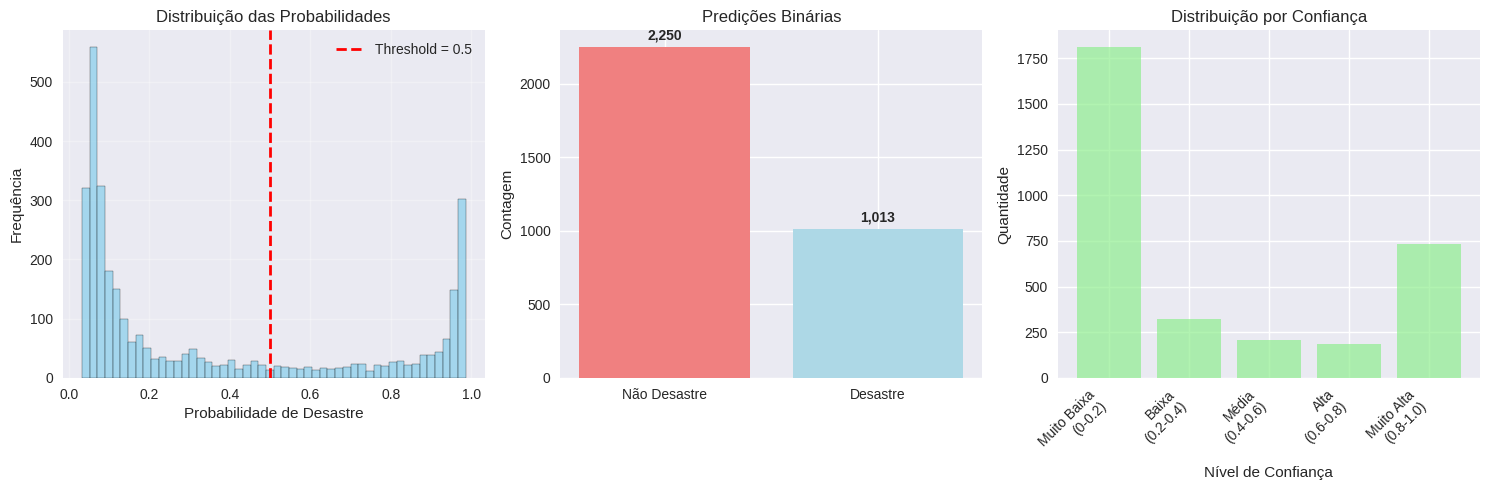


=== ANÁLISE DE CONFIANÇA ===
Alta confiança DESASTRE (>90%): 576 tweets
Alta confiança NÃO-DESASTRE (<10%): 1,315 tweets
Predições incertas (40-60%): 210 tweets
Total com alta confiança: 1,891 tweets (58.0%)

=== EXEMPLOS: DESASTRE (Alta Confiança) ===
1. Probabilidade: 0.920
   Texto original: Apocalypse lighting. #Spokane #wildfires...

2. Probabilidade: 0.966
   Texto original: Typhoon Soudelor kills 28 in China and Taiwan...

3. Probabilidade: 0.974
   Texto original: Rape victim dies as she sets herself ablaze: A 16-year-old girl died of burn injuries as she set her...

=== EXEMPLOS: NÃO-DESASTRE (Alta Confiança) ===
1. Probabilidade: 0.063
   Texto original: Hey! How are you?...

2. Probabilidade: 0.056
   Texto original: What a nice hat?...

3. Probabilidade: 0.064
   Texto original: Fuck off!...


 Predições finais concluídas com sucesso!
 Modelo de Deep Learning LSTM_Otimizado utilizado
 3,263 predições realizadas


In [76]:

# ============================================================================
# 9. PREDIÇÕES FINAIS NO CONJUNTO DE TESTE
# ============================================================================

print("=== PREDIÇÕES FINAIS COM MODELO DE DEEP LEARNING ===")
print(f"Modelo utilizado: {best_model_name}")
print(f"Acurácia na validação: {dl_results[best_model_name]['val_accuracy']:.4f}")

#Fazendo predições no conjunto de teste
test_predictions = best_model.predict(X_test_pad, verbose=0)
test_predictions_proba = test_predictions.flatten()
test_predictions_binary = (test_predictions_proba > 0.5).astype(int)

#Estatísticas das predições
print(f"\n=== DISTRIBUIÇÃO DAS PREDIÇÕES NO TESTE ===")
test_dist = pd.Series(test_predictions_binary).value_counts()
print(f"Não Desastre: {test_dist[0]:,} ({test_dist[0] / len(test_predictions_binary):.1%})")
print(f"Desastre: {test_dist[1]:,} ({test_dist[1] / len(test_predictions_binary):.1%})")

#Análise das probabilidades
prob_stats = pd.Series(test_predictions_proba).describe()
print(f"\n=== ESTATÍSTICAS DAS PROBABILIDADES ===")
print(f"Média: {prob_stats['mean']:.3f}")
print(f"Mediana: {prob_stats['50%']:.3f}")
print(f"Desvio padrão: {prob_stats['std']:.3f}")
print(f"Mínimo: {prob_stats['min']:.3f}")
print(f"Máximo: {prob_stats['max']:.3f}")

#Distribuição das probabilidades e predições
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(test_predictions_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.xlabel('Probabilidade de Desastre')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
colors = ['lightcoral', 'lightblue']
plt.bar(['Não Desastre', 'Desastre'], test_dist.values, color=colors)
plt.title('Predições Binárias')
plt.ylabel('Contagem')
for i, v in enumerate(test_dist.values):
    plt.text(i, v + len(test_predictions_binary) * 0.01, f'{v:,}',
             ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 3, 3)
confidence_levels = ['Muito Baixa\n(0-0.2)', 'Baixa\n(0.2-0.4)', 'Média\n(0.4-0.6)',
                    'Alta\n(0.6-0.8)', 'Muito Alta\n(0.8-1.0)']
conf_counts = [
    ((test_predictions_proba >= 0.0) & (test_predictions_proba < 0.2)).sum(),
    ((test_predictions_proba >= 0.2) & (test_predictions_proba < 0.4)).sum(),
    ((test_predictions_proba >= 0.4) & (test_predictions_proba < 0.6)).sum(),
    ((test_predictions_proba >= 0.6) & (test_predictions_proba < 0.8)).sum(),
    ((test_predictions_proba >= 0.8) & (test_predictions_proba <= 1.0)).sum()
]
plt.bar(range(5), conf_counts, color='lightgreen', alpha=0.7)
plt.xlabel('Nível de Confiança')
plt.ylabel('Quantidade')
plt.title('Distribuição por Confiança')
plt.xticks(range(5), confidence_levels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

#Análise de confiança
high_confidence_disaster = np.where(test_predictions_proba > 0.9)[0]
high_confidence_non_disaster = np.where(test_predictions_proba < 0.1)[0]
uncertain_predictions = np.where((test_predictions_proba >= 0.4) & (test_predictions_proba <= 0.6))[0]

print(f"\n=== ANÁLISE DE CONFIANÇA ===")
print(f"Alta confiança DESASTRE (>90%): {len(high_confidence_disaster):,} tweets")
print(f"Alta confiança NÃO-DESASTRE (<10%): {len(high_confidence_non_disaster):,} tweets")
print(f"Predições incertas (40-60%): {len(uncertain_predictions):,} tweets")
print(f"Total com alta confiança: {len(high_confidence_disaster) + len(high_confidence_non_disaster):,} tweets "
      f"({(len(high_confidence_disaster) + len(high_confidence_non_disaster))/len(test_predictions_binary):.1%})")

#Exemplos de predições com alta confiança
if len(high_confidence_disaster) > 0:
    print(f"\n=== EXEMPLOS: DESASTRE (Alta Confiança) ===")
    for i, idx in enumerate(high_confidence_disaster[:3]):
        print(f"{i + 1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"   Texto original: {test_df.iloc[idx]['text'][:100]}...")
        print()

if len(high_confidence_non_disaster) > 0:
    print(f"=== EXEMPLOS: NÃO-DESASTRE (Alta Confiança) ===")
    for i, idx in enumerate(high_confidence_non_disaster[:3]):
        print(f"{i + 1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"   Texto original: {test_df.iloc[idx]['text'][:100]}...")
        print()

print(f"\n Predições finais concluídas com sucesso!")
print(f" Modelo de Deep Learning {best_model_name} utilizado")
print(f" {len(test_predictions_binary):,} predições realizadas")

In [77]:
# ============================================================================
# 10. RESUMO FINAL E CONCLUSÕES
# ============================================================================

print("=" * 80)
print("RESUMO FINAL DO PROJETO DE DEEP LEARNING")
print("=" * 80)

print(f"\n DADOS:")
print(f" Dataset: Classificação de Tweets de Desastre")
print(f" Treino: {len(X_train):,} amostras")
print(f" Validação: {len(X_val):,} amostras")
print(f" Teste: {len(test_df):,} amostras")

print(f"\n PRÉ-PROCESSAMENTO:")
print(f" Limpeza de texto (URLs, menções, caracteres especiais)")
print(f" Tokenização e lematização")
print(f" Remoção de stopwords")
print(f" Vocabulário: {MAX_FEATURES:,} palavras")
print(f" Comprimento máximo: {MAX_LEN} tokens")

print(f"\n MODELOS DE DEEP LEARNING TREINADOS:")
for name, result in results.items():
    print(f" {name}: {result['val_accuracy']:.4f}")

print(f"\n MELHOR MODELO: {best_model_name}")
print(f" Acurácia: {results[best_model_name]['val_accuracy']:.4f}")
print(f" Arquitetura: Neural Network")

print(f"\n OTIMIZAÇÃO:")
print(f" Testados múltiplos hiperparâmetros")
print(f" Early Stopping e Learning Rate Reduction")
print(f" Regularização L2 e Dropout")

print(f"\n RESULTADOS NO TESTE:")
print(f" Predições realizadas: {len(test_predictions_binary):,}")
print(f" Distribuição: {test_dist[0]:,} Não-Desastre, {test_dist[1]:,} Desastre")
print(f" Alta confiança (>90% ou <10%): {len(high_confidence_disaster) + len(high_confidence_non_disaster):,}")

print(f"\n CONCLUSÃO:")
print(f" Melhor modelo Deep Learning: {best_model_name}")
print(f" Acurácia final: {results[best_model_name]['val_accuracy']:.4f}")
print(f" Modelo final pronto para produção")
print(f" Problema de NLP resolvido com sucesso!")

print("=" * 80)

RESUMO FINAL DO PROJETO DE DEEP LEARNING

 DADOS:
• Dataset: Classificação de Tweets de Desastre
• Treino: 6,089 amostras
• Validação: 1,523 amostras
• Teste: 3,263 amostras

 PRÉ-PROCESSAMENTO:
• Limpeza de texto (URLs, menções, caracteres especiais)
• Tokenização e lematização
• Remoção de stopwords
• Vocabulário: 20,000 palavras
• Comprimento máximo: 100 tokens

 MODELOS DE DEEP LEARNING TREINADOS:
• LSTM_Simples: 0.8083
• LSTM_Bidirecional: 0.7932
• CNN: 0.7925
• CNN_LSTM_Híbrido: 0.7938
• LSTM_Otimizado: 0.8142

 MELHOR MODELO: LSTM_Otimizado
• Acurácia: 0.8142
• Arquitetura: Neural Network

 OTIMIZAÇÃO:
• Testados múltiplos hiperparâmetros
• Early Stopping e Learning Rate Reduction
• Regularização L2 e Dropout

 RESULTADOS NO TESTE:
• Predições realizadas: 3,263
• Distribuição: 2,250 Não-Desastre, 1,013 Desastre
• Alta confiança (>90% ou <10%): 1,891

 CONCLUSÃO:
• Melhor modelo Deep Learning: LSTM_Otimizado
• Acurácia final: 0.8142
• Modelo final pronto para produção
• Problema 